In [1]:
import h5py
import librosa
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.signal
import soundfile as sf
import sys
sys.path.append('../src')
import localmodule

from matplotlib import pyplot as plt

0.526848741039 0.236378337013
0.832119598188 0.366149385597
0.811635091051 0.266367733503
0.943765867481 0.426472261894
0.788651096016 0.38448601043


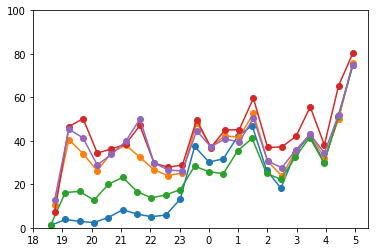

In [70]:
%matplotlib inline

# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)

threshold_ids =\
      [[103, 102,  79, 115,   0,  91,   0, 106,   0, 135],
       [205,   0, 207,   0, 189, 170, 206, 193, 191, 184],
       [143,   0, 137, 150,   0, 158,   0, 145, 154, 118],
       [130, 158,   0, 136, 162, 133, 174, 134, 158, 140],
       [134, 131, 203, 126, 140, 131, 123, 121, 125, 139],
       [159, 186, 130, 133, 140, 161, 170, 141, 166, 168]]
threshold_ids = np.array(threshold_ids)

trials =\
      [[4, 8, 9, 6, 3, 0, 2, 1, 5, 7],
       [1, 3, 0, 9, 2, 6, 4, 8, 5, 7],
       [1, 4, 6, 8, 0, 9, 7, 5, 3, 2],
       [2, 9, 1, 5, 6, 3, 4, 8, 7, 0],
       [2, 8, 1, 0, 4, 9, 5, 7, 3, 6],
       [4, 9, 8, 6, 1, 2, 5, 3, 7, 0]]
trials = np.array(trials)

thresholds = 1.0 - np.concatenate((
    np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
))
n_thresholds = len(thresholds)

tolerance = 0.5 # in seconds


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


# Define directory for model.
test_unit_id = 1
aug_str = "all"
model_name = "icassp-convnet"
model_dir = os.path.join(models_dir, model_name)


# Load annotation.
annotation_path = os.path.join(annotations_dir,
    test_unit_str + ".txt")
annotation = pd.read_csv(annotation_path, '\t')
begin_times = np.array(annotation["Begin Time (s)"])
end_times = np.array(annotation["End Time (s)"])
relevant = 0.5 * (begin_times + end_times)
relevant = np.sort(relevant)
n_relevant = len(relevant)

plt.figure(figsize=(6,4))


# Loop over trials.
for trial_id_id in [4, 6, 7, 8, 9]:
    # Pick trial.
    trial_id = trials[test_unit_id, trial_id_id]


    # Pick threshold.
    threshold_id = threshold_ids[test_unit_id, trial_id]


    # Load prediction.
    test_unit_str = units[test_unit_id]
    unit_dir = os.path.join(model_dir, test_unit_str)
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)
    prediction_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-predictions.csv"])
    prediction_path = os.path.join(trial_dir, prediction_name)
    prediction_df = pd.read_csv(prediction_path)
    odf = np.array(prediction_df["Predicted probability"])
    timestamps = np.array(prediction_df["Timestamp"])


    # Select peaks.
    threshold = thresholds[threshold_id]
    peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
    selected = timestamps[peak_locations]


    # Match events.
    selected_relevant = mir_eval.util.match_events(
        relevant, selected, tolerance)
    tp_relevant_ids = list(zip(*selected_relevant))[0]
    tp_relevant_times = [relevant[i] for i in tp_relevant_ids]
    tp_selected_ids = list(zip(*selected_relevant))[1]
    tp_selected_times = [selected[i] for i in tp_selected_ids]


    # List false alarms
    fp_times = [selected[i] for i in range(len(selected))
        if i not in tp_selected_ids]


    # List missed detections
    fn_times = [relevant[i] for i in range(len(relevant))
        if i not in tp_relevant_ids]

    n_bins = 22;

    tp_x, tp_y = np.histogram(tp_relevant_times, bins=n_bins);
    fp_x, fp_y = np.histogram(fp_times, bins=n_bins);
    fn_x, fn_y = np.histogram(fn_times, bins=n_bins);

    P = tp_x / (np.finfo(float).eps + tp_x + fp_x)
    R = tp_x / (np.finfo(float).eps + tp_x + fn_x)
    F = (2*P*R) / (np.finfo(float).eps + P + R)
    
    print(threshold, np.mean(F))

    #
    #plt.plot(tp_y[1:] / 3600, 100 * P[:] , '-o')
    #plt.plot(tp_y[1:] / 3600, 100 * R[:] , '-o')
    plt.plot(tp_y[1:] / 3600, 100 * F[:], '-o')
    plt.ylim(0, 100)
    plt.xticks(range(12), [str(np.mod(n, 24)) for n in range(-6, 6)]);

    #plt.savefig("icassp-convnet_aug-all_trial-7_F-through-time.eps")

In [63]:
P

array([ 0.05154639,  0.43181818,  0.33333333,  0.22429907,  0.25      ,
        0.33050847,  0.46721311,  0.2295082 ,  0.17085427,  0.17948718,
        0.40837696,  0.29375   ,  0.32653061,  0.35690236,  0.46478873,
        0.23461538,  0.25      ,  0.28      ,  0.35955056,  0.27992278,
        0.48387097,  0.72558341])